# Representacion no estructurada de canciones de los 80s

## Importacion de datos

In [ ]:
%pip install scikit-learn matplotlib pandas seaborn nltk pyLDAvis spacy
%pip install --upgrade numpy==2.0.0
%pip install --upgrade scipy==1.9.3
%pip install --upgrade gensim

In [30]:
# Importacion de las letras desde el directorio de letras
import os
import pandas as pd

# Crear dataframe con las letras: Cancion, Letra y Artista
canciones = []
for file in os.listdir('letras'):
    with open(f'letras/{file}', encoding='utf-8') as f:
        cancion = ' '.join(file.split('.')[0:-1]).strip()
        nombre = ' '.join(cancion.split('-')[0:-1]).strip()
        artista = cancion.split('-')[-1].strip()
        letras = f.read()
        canciones.append([nombre, artista, letras])

canciones = pd.DataFrame(canciones, columns=['Cancion', 'Artista', 'Letra'])

canciones.to_csv('canciones.csv', index=False)

canciones.head()

,Cancion,Artista,Letra
0,A esa,Pimpinela,"L VEN AQUI, QUIERO DECIRTE ALGO...\n\nA esa, q..."
1,A quién le importa,Alaska y Dinarama,La gente me señala\n\nme apuntan con el dedo\n...
2,Amante Bandido,Miguel Bosé,Yo seré el viento que va\n\nnavegare por tu os...
3,Amor Eterno,Rocío Dúrcal,Tu eres la tristeza de mis ojos \nque lloran e...
4,Ausencia,Héctor Lavoe,Ha terminado otro capítulo en mi vida \nLa muj...


## Representacion TF-IDF

### Entendimiento y preprocesamiento de datos

In [30]:
letras = canciones['Letra'].values.tolist()
len(letras)

105

Importacion de la libreria de stopwords y definicion de una funcion para filtrar las canciones.

In [31]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
misstop=stopwords.words('spanish')+["á","Y"]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\esteb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
def filtrado(texto):
    filtrados=[word for word in texto if word not in misstop]
    return(filtrados)

La limpieza incluira:

**a)** pasar a minúsculas

**b)** retirar páginas web

**c)** quitar saltos de línea y tabuladores

**d)** retirar stopwords

**e)** retirar menciones

**f)** unir todo de nuevo

**g)** eliminar letras solas


In [33]:
import re
nltk.download("punkt")
nltk.download('punkt_tab')
filtradito=[]
# Eliminar menciones y páginas web
for i in range(len(letras)):
    letras[i] = re.sub("\""," ",letras[i])
    letras[i] = re.sub ("\n|\t"," ",letras[i])
    letras[i]=letras[i].lower()
    letras[i] = re.sub(r'\s+[a-zA-Z]\s+', ' ', letras[i])
    letras[i] = re.sub(r'\xad+', ' ', letras[i], flags=re.I)
    breve=nltk.tokenize.word_tokenize(letras[i],language="spanish")
    tempfilt=filtrado(breve)
    filtradito.append(tempfilt)
    
unidito=[]
for element in filtradito:
    unidito.append(" ".join(element))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\esteb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\esteb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [34]:
unidito[0]

'l ven aqui , quiero decirte ... , aparta , roba tiempo , alma cuerpo , ve dile ... quieres ? venga , valor , muestre cara hable frente si quiere amor ... ? , contigo va vestida princesa , , hace preguntas siempre está¡ dispuesta , , vete dile ... ? venga ... ? doy lugar ... quieres probar ? recoja mesa , lave ropa todas miserias ... quieres demostrar ? venga , juegue ... vas conseguir ? quiero ver si capaz darte cosas di ... , ... vete dile , venga ... , pone tan mal capaz hacerme volver vivir ilusiones perdidas . , hace hablar debo cosas hace tiempo das ... , puede costar hacerte feliz hora día ? , toca vivir ninguna tristeza , alegrí a. vete dile .. ? venga ... ? doy lugar ... quieres probar ? recoja mesa , lave ropa todas miserias ... quieres demostrar ? venga , juegue ... vas conseguir ? quiero ver si capaz darte cosas di ... venga ... ... doy lugar ... quieres probar ... recoja mesa lave ropa todas miserias quieres demostrar ... venga juegue ... vas conseguir ... quiero ver si ca

### Determinacion de Topicos

Importacion de librerias para topicos de sklearn

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

Estraccion de topicos

In [36]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [52]:
vectores=TfidfVectorizer(max_df=0.9,min_df=2,max_features=1000)
tfslimpio=vectores.fit_transform(unidito)
nombreslimpio=vectores.get_feature_names_out()
nmflimpio = NMF(n_components=6, random_state=1, l1_ratio=.5, init='nndsvd').fit(tfslimpio)
no_top_words=10
display_topics(nmflimpio, nombreslimpio, no_top_words)

Topic 0:
si quiero amor sé vete vos día ver siempre ahora
Topic 1:
vida pido why toda así asi amor nunca prefiero ahora
Topic 2:
oh bajo parte playa calienta cerca aquí sol luna busco
Topic 3:
desaparecer ayer amor muralla divide mirando parado vuelve viene realidad
Topic 4:
sacarla ayudarla pozo aca puedo escucho abajo calla mirarla ciego
Topic 5:
voy nadie puede vas nene vez nunca mundo fiesta veo


In [38]:
len(nombreslimpio)

790

Utilizacion de conteos para LDA (Latent Dirilchet Allocation)

In [53]:
paralda = CountVectorizer(max_df=0.9, min_df=2, max_features=1000)
tflda=paralda.fit_transform(unidito)
nombreslda=paralda.get_feature_names_out()
lda = LatentDirichletAllocation(n_components=6, max_iter=3, learning_method='online', learning_offset=50.,random_state=0).fit(tflda)
id_topico=lda.fit_transform(tflda)
display_topics(lda,nombreslda,no_top_words)

Topic 0:
vida nunca voy tan mundo oh toda ganas ay verte
Topic 1:
amor rock si debajo ayer nene solo siempre um vas
Topic 2:
oh nadie we gente vete puede van in bis vos
Topic 3:
na amor quiero si ven eu vez puedo noches vida
Topic 4:
si amo lluvia je amor ahora mañana sé vos quiero
Topic 5:
importa mas si pasa fiesta solo quiero asi nunca siempre


Pertenencia de cada documento a su topico

In [40]:
doc_topic = nmflimpio.transform(tfslimpio)
topic_most_pr=[]
for n in range(doc_topic.shape[0]):
    topic_most_pr.append(doc_topic[n].argmax())

In [41]:
canciones["nmf"]=topic_most_pr
ver_cerveza=canciones[["Cancion","nmf"]]
display(ver_cerveza)

,Cancion,nmf
0,A esa,0
1,A quién le importa,1
2,Amante Bandido,0
3,Amor Eterno,0
4,Ausencia,0
...,...,...
100,Y cómo es él,1
101,Yo No Te Pido La Luna,1
102,Yo te avisé,0
103,Ámame en cámara lenta,1


### Visualizacion de resultados

Gensim y pyLDAvis para ver los resultados de LDA

In [42]:
import gensim
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

In [43]:
import spacy
spacy.cli.download("es_core_news_sm")
nlp=spacy.load("es_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [44]:
preparado = []
for texto in letras:
  doc = nlp(texto) 
  preparado.append([token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV'] and token.text!="cerveza" ])
preparado[0:2]

[['ver',
  'aqui',
  'querer',
  'decir tú',
  'apartar',
  'robar',
  'tiempo',
  'alma',
  'cuerpo',
  'ver',
  'dile',
  'quier',
  'venir',
  'tener',
  'valor',
  'mostrar',
  'cara',
  'hablar',
  'frente',
  'querer',
  'amor',
  'estar',
  'vestido',
  'princesa',
  'no',
  'hacer',
  'pregunta',
  'siempre',
  'dispuesto',
  'vete',
  'dile',
  'venir',
  'dar',
  'lugar',
  'querer',
  'probar',
  'recojar',
  'mesa',
  'lave',
  'ropar',
  'miseria',
  'querer',
  'demostrar',
  'venir',
  'jugar',
  'ir',
  'conseguir',
  'querer',
  'ver',
  'capaz',
  'darte',
  'cosa',
  'dar',
  'vete',
  'dile',
  'venir',
  'poner',
  'tanto',
  'mal',
  'capaz',
  'hacer yo',
  'volver',
  'vivir',
  'ilusión',
  'perdido',
  'hacer',
  'hablar',
  'deber',
  'cosa',
  'hacer',
  'tiempo',
  'ya',
  'no',
  'dar',
  'costar',
  'hacerte',
  'feliz',
  'hora',
  'día',
  'no',
  'tocar',
  'vivir',
  'tristeza',
  'alegrí',
  'a.',
  'vete',
  'dile',
  'venir',
  'dar',
  'lugar',
  

Preparacion del conteo y definicion de un diccionario a gensim

In [45]:
id2word=Dictionary(preparado)
corpus = [id2word.doc2bow(element) for element in preparado]

Tecnica basada en PMI que calcula la coherencia del numero de topicos.

In [46]:
coherencias=[]
for topicos in range(1,10):
  modelito=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=topicos,random_state=100,update_every=1,chunksize=40,passes=10,alpha='auto',per_word_topics=True)
  coherence_model_lda = CoherenceModel(model=modelito, texts=preparado, dictionary=id2word, coherence='c_v')
  coherencias.append(coherence_model_lda.get_coherence())
print(coherencias)

[0.2557710542554721, 0.34066419642474516, 0.3690207402775165, 0.3949397450515082, 0.3392860864675516, 0.39703025753759363, 0.39654668633470463, 0.3671069225280206, 0.36828126850758064]


El resultado sugiere 6 topicos

In [47]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=40,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [48]:
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.074*"no" + 0.024*"amor" + 0.023*"tener" + 0.016*"ver" + 0.013*"siempre" + '
  '0.012*"ya" + 0.010*"saber" + 0.010*"hacer" + 0.009*"�" + 0.009*"volver"'),
 (1,
  '0.015*"noche" + 0.014*"rock" + 0.013*"más" + 0.013*"perché" + 0.012*"amor" '
  '+ 0.012*"bastar" + 0.011*"signo" + 0.009*"lento" + 0.009*"cámara" + '
  '0.009*"ámame"'),
 (2,
  '0.015*"ir" + 0.011*"eu" + 0.010*"agüita" + 0.009*"creer" + '
  '0.008*"desaparecer" + 0.008*"non" + 0.008*"unir" + 0.008*"il" + '
  '0.007*"negra" + 0.007*"saber"'),
 (3,
  '0.046*"no" + 0.035*"vida" + 0.032*"querer" + 0.020*"pedir" + 0.013*"amor" + '
  '0.013*"solo" + 0.012*"ver" + 0.012*"hacer" + 0.010*"tanto" + 0.009*"ir"'),
 (4,
  '0.083*"no" + 0.020*"vo" + 0.013*"decir" + 0.013*"querer" + 0.011*"juego" + '
  '0.011*"gente" + 0.011*"ir" + 0.010*"hacer" + 0.009*"preguntar" + '
  '0.008*"ya"'),
 (5,
  '0.051*"no" + 0.047*"amar" + 0.034*"más" + 0.022*"gana" + 0.018*"ahora" + '
  '0.017*"verter" + 0.017*"mañana" + 0.017*"nunca" + 0.016*"lluvi

In [49]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.134524 -0.084280       1        1  27.864031
3      0.121747 -0.069154       2        1  25.967387
2     -0.139635  0.049268       3        1  12.388288
1     -0.191455 -0.111360       4        1  11.951935
5      0.023921  0.209585       5        1  11.202745
4      0.050898  0.005941       6        1  10.625614, topic_info=       Term        Freq       Total Category  logprob  loglift
37       no  447.000000  447.000000  Default  30.0000  30.0000
174    amar   53.000000   53.000000  Default  29.0000  29.0000
104    vida   94.000000   94.000000  Default  28.0000  28.0000
201     más   77.000000   77.000000  Default  27.0000  27.0000
206   pedir   49.000000   49.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
49    tanto    6.216485   47.761187   Topic6  -5.0642   0.2029
161  pensar    5.545721   34.087171   Topic6  -5.1784   0.4260
261     vez    4.722253   33.959367   Topic6  -5.3392   0.2690
56      ver    4.867643   78.980561   Topic6  -5.3088  -0.5447
23   hablar    4.025922   14.117302   Topic6  -5.4987   0.9873

[337 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1072      1  0.931350    agua
1584      3  0.911682  agüita
337       4  0.840495     ahh
63        1  0.194566   ahora
63        2  0.243207   ahora
...     ...       ...     ...
61        6  0.145888      ya
2355      4  0.922161   ámame
2112      1  0.651310       �
2112      4  0.135690       �
2112      5  0.189965       �

[469 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 6, 5])

## Representación basada en Embeddings

El objetivo de esta representación es construir un mapa (p.e., con t-sne) que muestre la posición relativa de las canciones según su representación de texto con explicaciones pertinentes.

### Carga del modelo

Carga del modelo de embeddings extraido de https://github.com/dccuchile/spanish-word-embeddings
Específicamente se utiliza el modelo "Word2Vec embeddings from SBWC"

In [ ]:
%pip install POT

In [39]:
import gensim
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string

In [40]:
from gensim.models import KeyedVectors
modelo = KeyedVectors.load_word2vec_format('SBW-vectors-300-min5.bin.gz', binary=True)

### Preprocesamiento

In [41]:
nltk.download('punkt')
nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\esteb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\esteb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
def preprocess_lyrics(lyrics):
    # Remove punctuation, numbers, and convert to lowercase
    lyrics = re.sub(r'\d+', '', lyrics)
    lyrics = lyrics.translate(str.maketrans('', '', string.punctuation))
    lyrics = lyrics.lower()
    
    # Tokenize the lyrics
    tokens = word_tokenize(lyrics)
    
    # Remove stop words
    tokens = [word for word in tokens if word not in spanish_stopwords]
    
    return tokens

In [44]:
canciones.head()

,Cancion,Artista,Letra
0,A esa,Pimpinela,"L VEN AQUI, QUIERO DECIRTE ALGO...\n\nA esa, q..."
1,A quién le importa,Alaska y Dinarama,La gente me señala\n\nme apuntan con el dedo\n...
2,Amante Bandido,Miguel Bosé,Yo seré el viento que va\n\nnavegare por tu os...
3,Amor Eterno,Rocío Dúrcal,Tu eres la tristeza de mis ojos \nque lloran e...
4,Ausencia,Héctor Lavoe,Ha terminado otro capítulo en mi vida \nLa muj...


### Reduccion de dimensiones usando t-SNE

In [43]:
def get_song_embedding(lyrics):
    tokens = preprocess_lyrics(lyrics)
    vectors = [modelo[word] for word in tokens if word in modelo]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300) 

In [45]:
song_embeddings = np.array([get_song_embedding(lyrics) for lyrics in canciones['Letra']])

In [53]:
tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne_model.fit_transform(song_embeddings)

tsne_df = pd.DataFrame({
    'primer_componente': tsne_results[:, 0],
    'segundo_componente': tsne_results[:, 1],
    'Cancion': canciones['Cancion'],
    'Artista': canciones['Artista']
})

tsne_df.to_csv('tsne.csv', index=False)

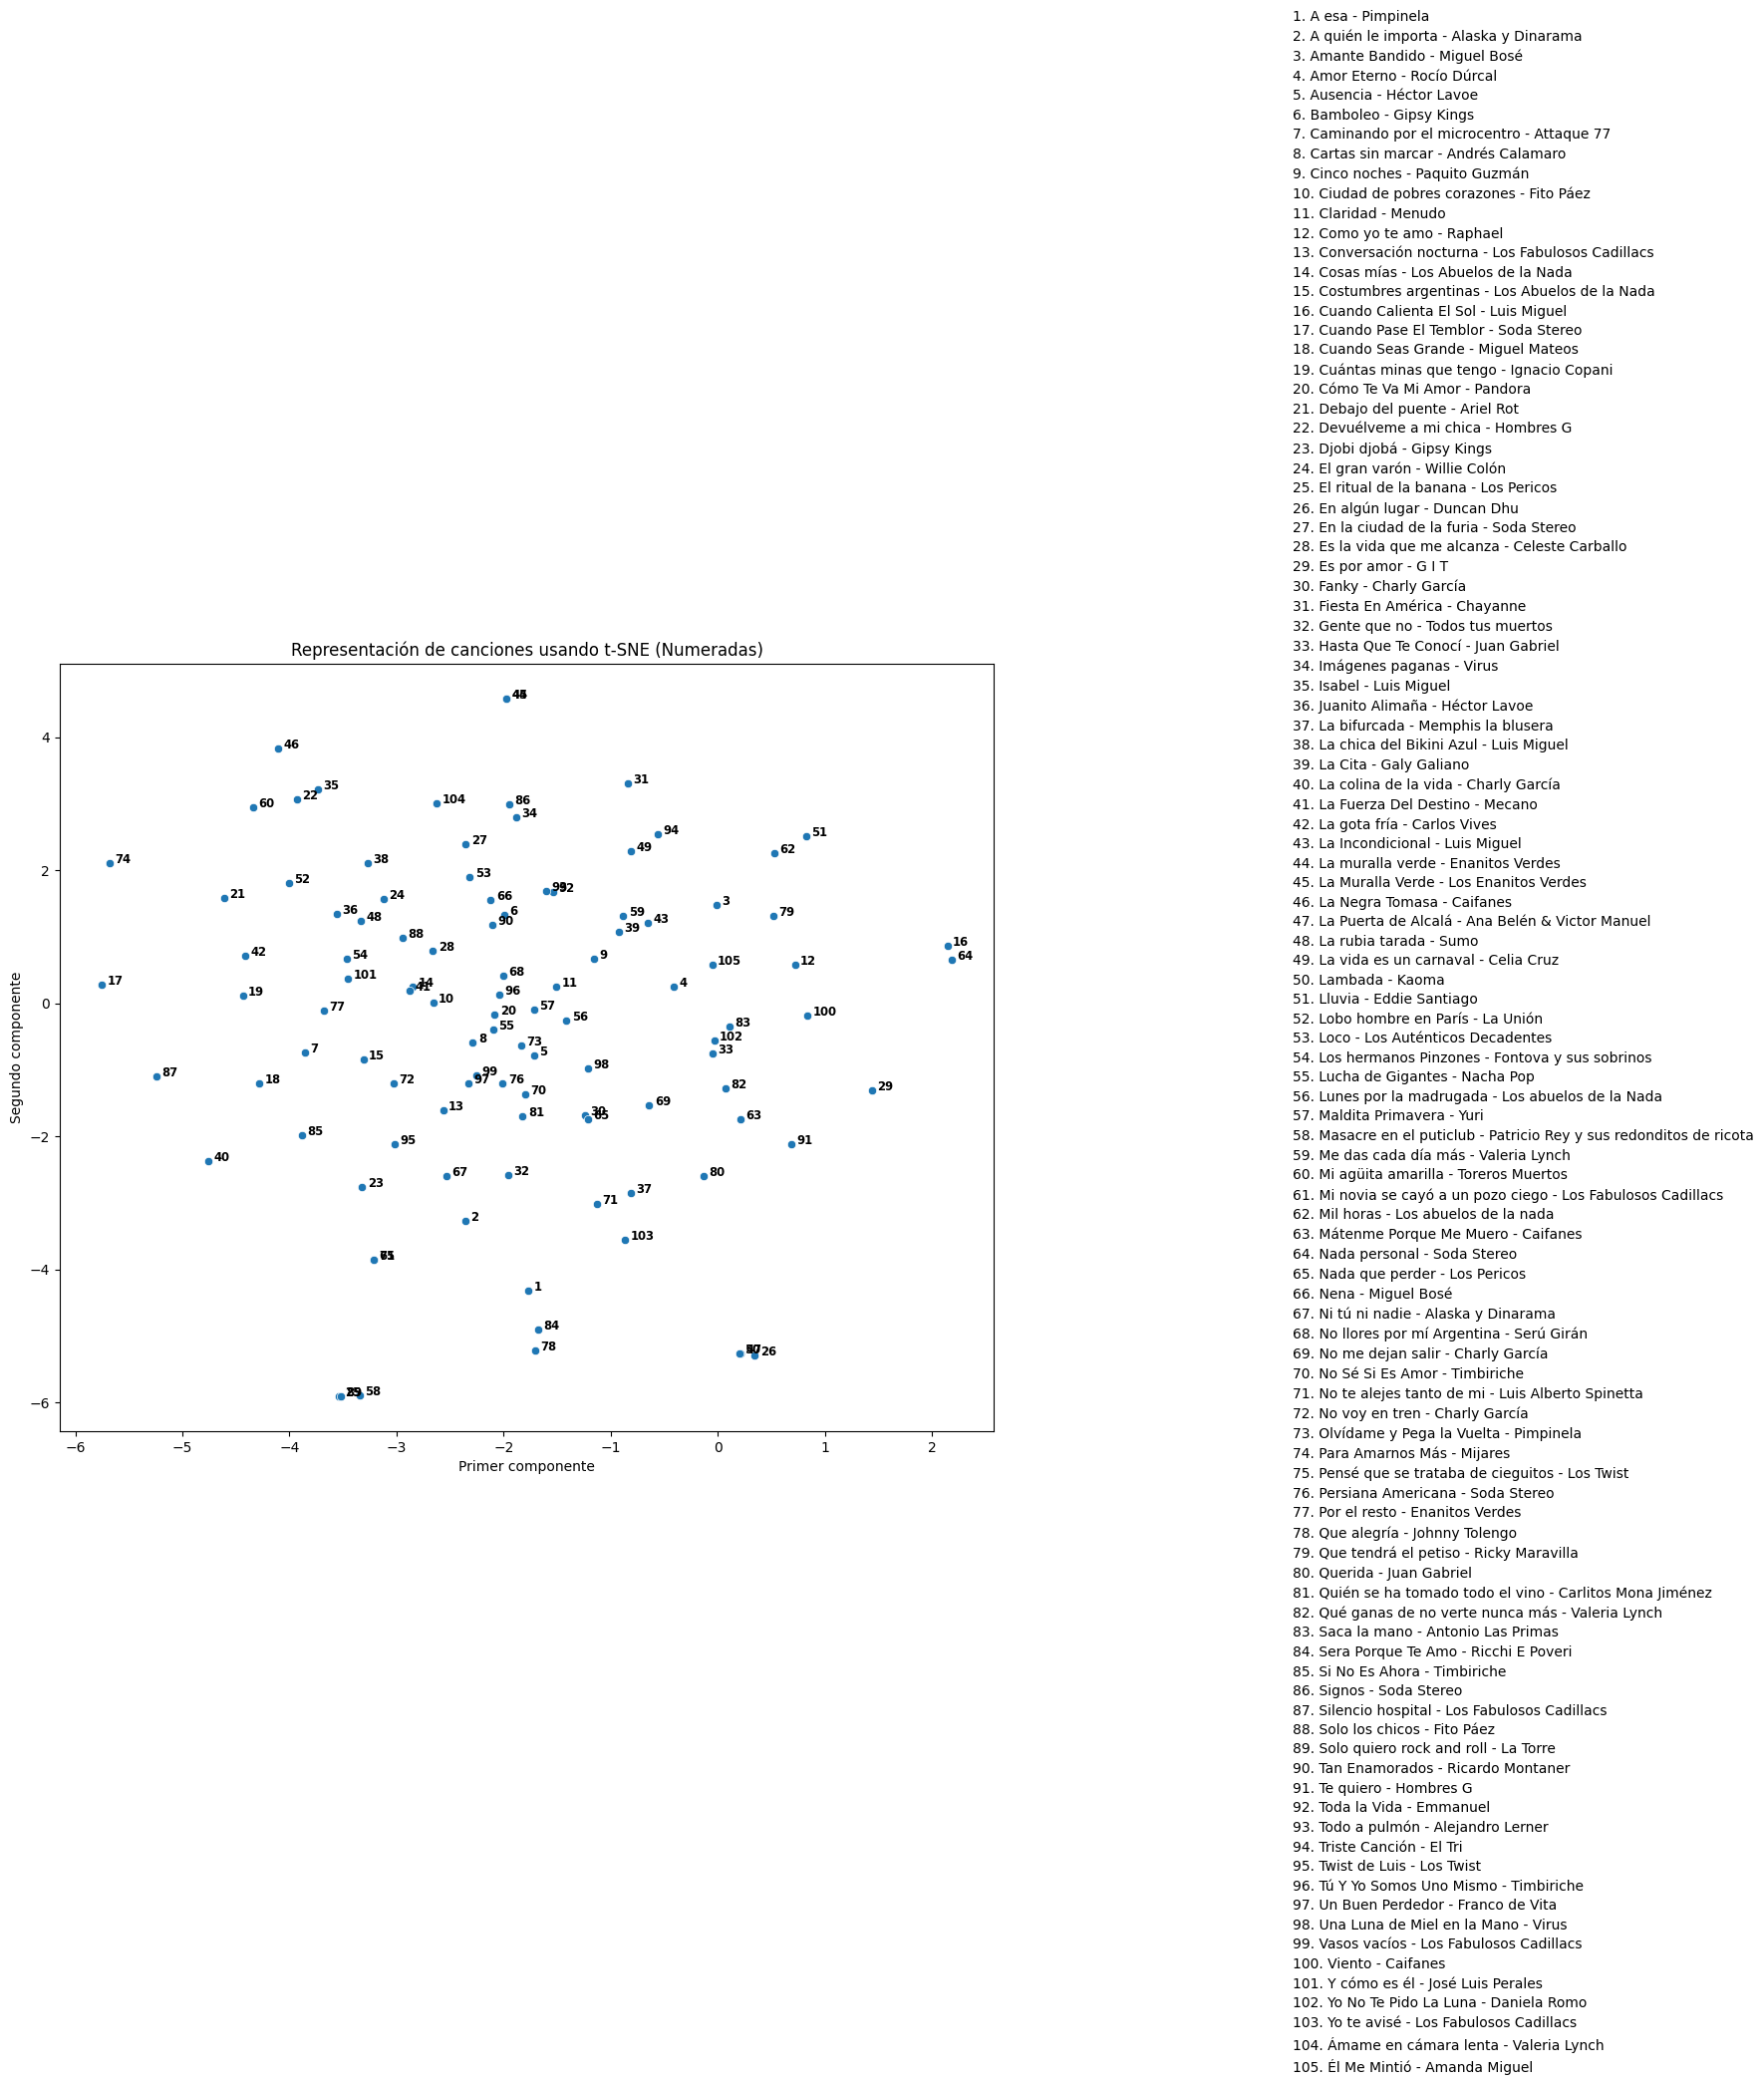

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura más grande
plt.figure(figsize=(15, 10))

# Crear el gráfico de dispersión
graf1 = sns.scatterplot(x="primer_componente", y="segundo_componente", data=tsne_df)

# Numerar cada punto en lugar del título de la canción
for line in range(0, tsne_df.shape[0]):
    plt.text(tsne_df.primer_componente[line] + 0.05, 
             tsne_df.segundo_componente[line], 
             str(line + 1),  # Mostrar el número en lugar del título
             horizontalalignment='left', 
             size='small', 
             color='black', 
             weight='semibold')

# Crear la lista numerada de canciones para colocarla en el gráfico
song_list = "\n".join([f"{i+1}. {cancion} - {artista}" for i, (cancion, artista) in enumerate(zip(tsne_df['Cancion'], tsne_df['Artista']))])

# Colocar la lista numerada de canciones en una esquina del gráfico
plt.gcf().text(0.95, 0.5, song_list, fontsize=10, va='center', ha='left', linespacing=1.5)

# Agregar título y etiquetas de ejes
plt.title("Representación de canciones usando t-SNE (Numeradas)")
plt.xlabel("Primer componente")
plt.ylabel("Segundo componente")

# Ajustar los márgenes para dar espacio a la lista de canciones
plt.subplots_adjust(right=0.75)

# Mostrar el gráfico
plt.show()

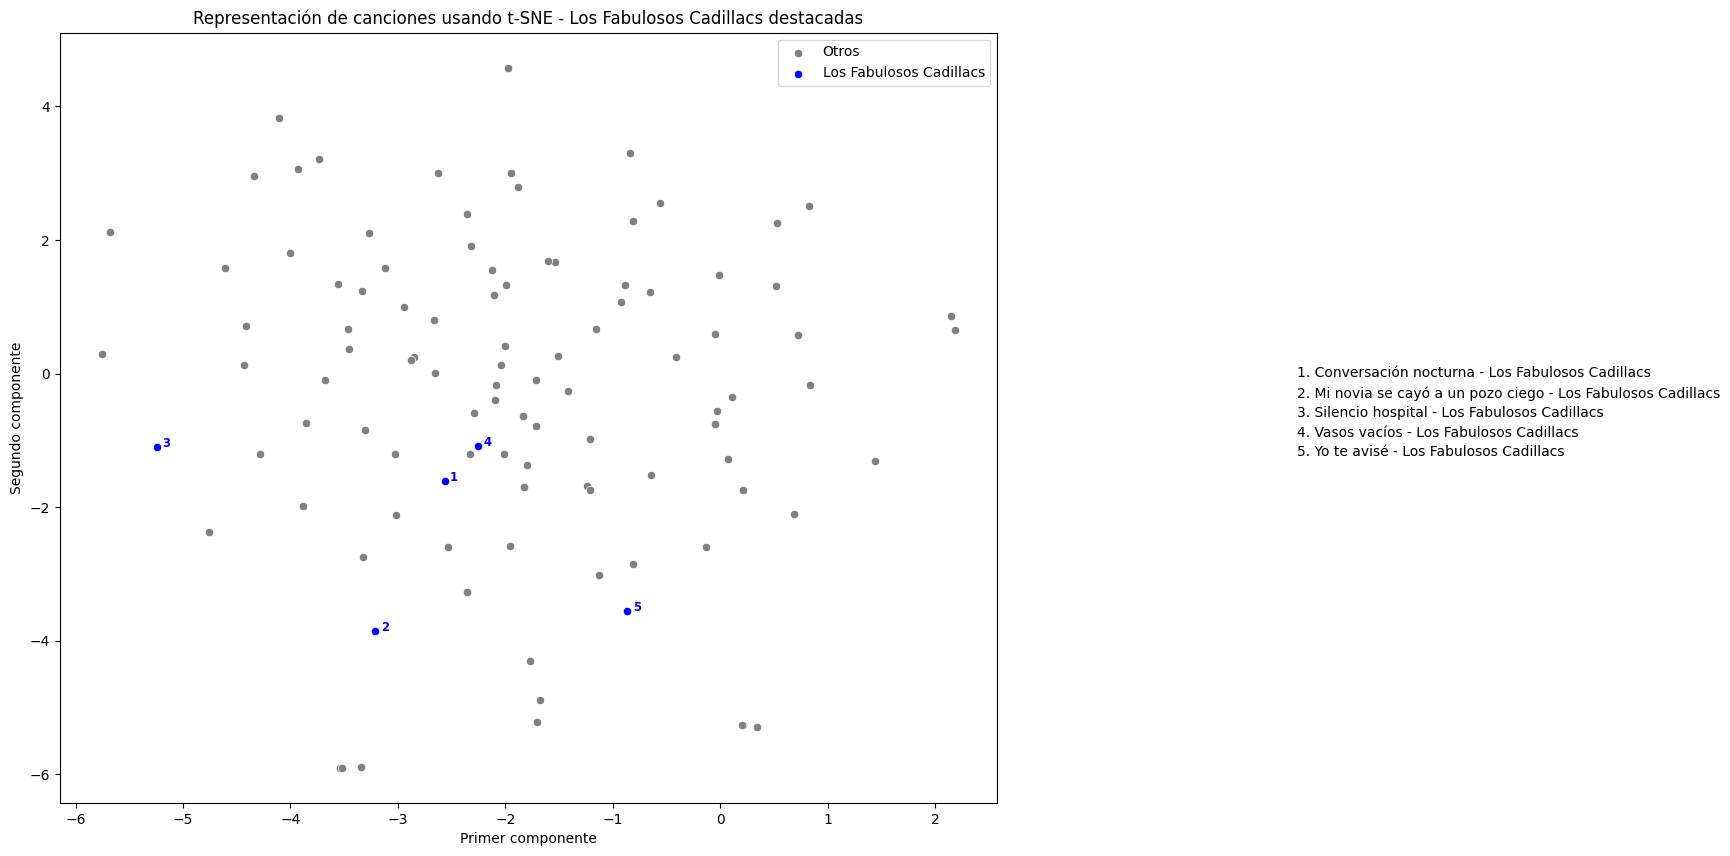

In [68]:
# Identify the artist with the most songs
artist_counts = tsne_df['Artista'].value_counts()
artist = artist_counts.idxmax()

# Filter the dataframe for only the songs by the top artist
artist_songs = tsne_df[tsne_df['Artista'] == artist]

# Plotting with the top artist's songs highlighted
plt.figure(figsize=(15, 10))

# Plot all songs
sns.scatterplot(x="primer_componente", y="segundo_componente", data=tsne_df, label="Otros", color="gray")

# Highlight songs from the top artist
sns.scatterplot(x="primer_componente", y="segundo_componente", data=artist_songs, label=artist, color="blue")

# Add text labels for the top artist's songs
for line in range(0, artist_songs.shape[0]):
    plt.text(artist_songs.primer_componente.iloc[line] + 0.05, 
             artist_songs.segundo_componente.iloc[line], 
             str(line + 1),  # Number the points by their index in this subset
             horizontalalignment='left', 
             size='small', 
             color='blue', 
             weight='semibold')

# Add the list of top artist's songs on the side
song_list = "\n".join([f"{i+1}. {cancion} - {artista}" for i, (cancion, artista) in enumerate(zip(artist_songs['Cancion'], artist_songs['Artista']))])
plt.gcf().text(0.95, 0.5, song_list, fontsize=10, va='center', ha='left', linespacing=1.5)

# Add title and axis labels
plt.title(f"Representación de canciones usando t-SNE - {artist} destacadas")
plt.xlabel("Primer componente")
plt.ylabel("Segundo componente")

# Adjust margins to fit the song list
plt.subplots_adjust(right=0.75)

# Show the plot
plt.show()

